In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-whitegrid')

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import max_norm


from sklearn import metrics


In [90]:
# Retreive the dataset
import os
import tarfile
import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets','housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path= HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,'housing.csv')
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()

In [91]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [92]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [93]:
def check_for_missing_values(df):
    """ check for missing data in columns """
    for column in df:
        print(f"{column}: " + str(df[column].isnull().sum()))

check_for_missing_values(housing)

longitude: 0
latitude: 0
housing_median_age: 0
total_rooms: 0
total_bedrooms: 207
population: 0
households: 0
median_income: 0
median_house_value: 0
ocean_proximity: 0


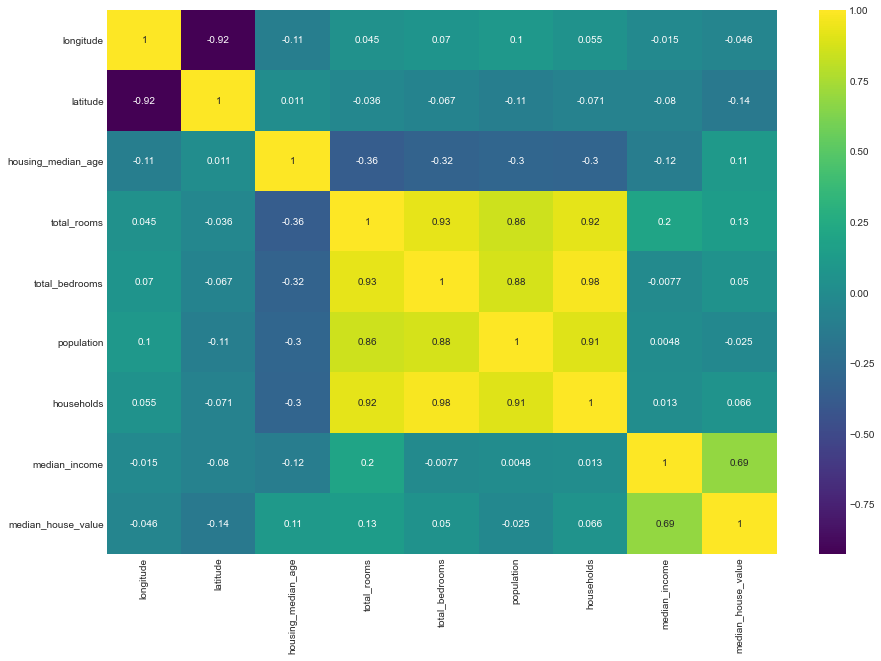

In [94]:
# Check on feature correlations
plt.figure(figsize=(15,10))
sns.heatmap(data=housing.corr(), annot=True, cmap='viridis')
plt.show()

In [95]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

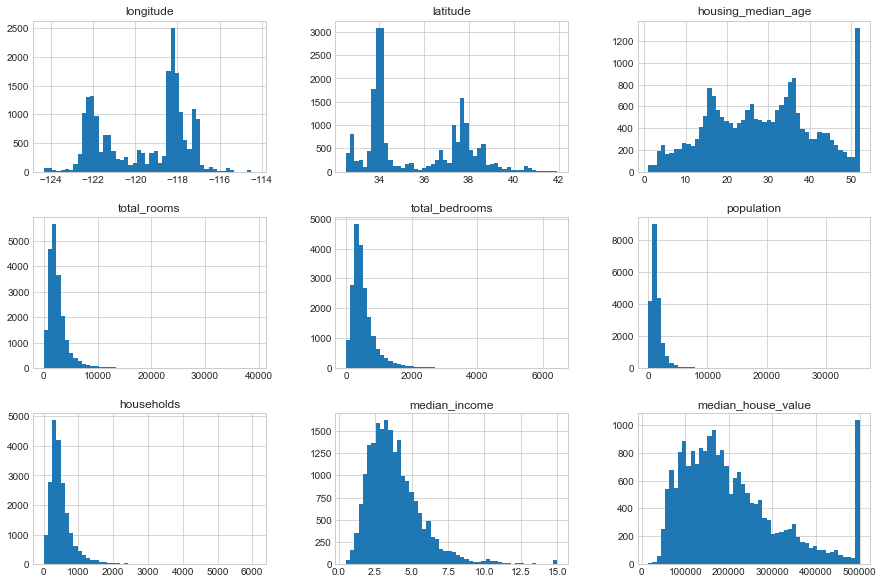

In [96]:
housing.hist(bins=50, figsize=(15,10))
plt.show()

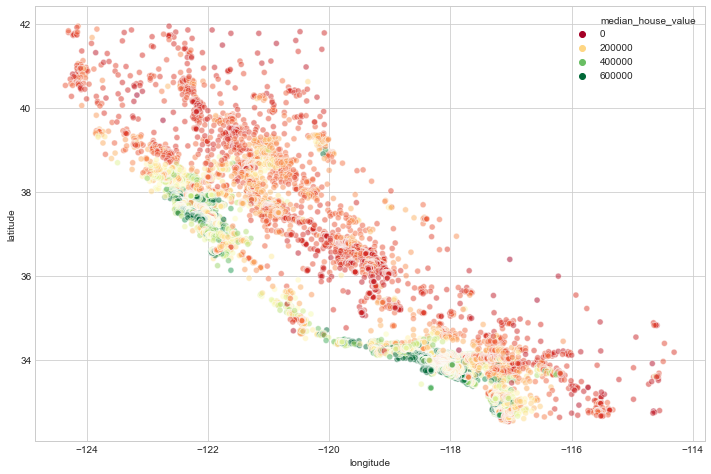

In [97]:
# Create a pseudo geographic plot
plt.figure(figsize=(12,8))
sns.scatterplot(data= housing, x='longitude', y='latitude', hue='median_house_value', cmap='coolwarm',
               palette='RdYlGn', alpha = 0.5)
plt.show()

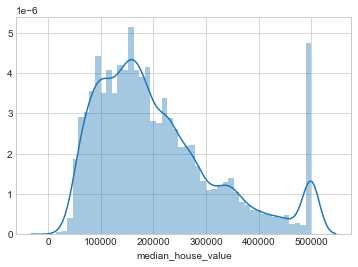

In [98]:
sns.distplot(housing['median_house_value'])
plt.show()

In [99]:
# House Value seems to be capped on the upper end.  Drop homes that fall into that category
housing = housing[housing['median_house_value'] <= 500000]

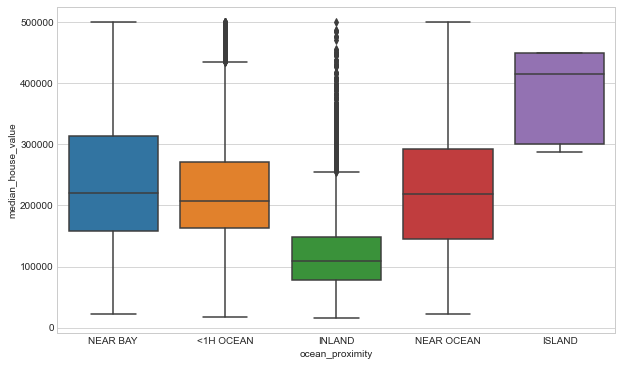

In [100]:
plt.figure(figsize=(10,6))
sns.boxplot(data=housing, x='ocean_proximity', y='median_house_value')
plt.show()

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

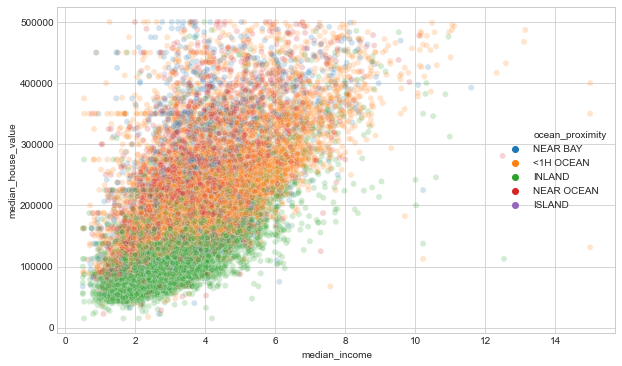

In [101]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=housing, x='median_income', y='median_house_value', alpha=0.2, hue='ocean_proximity')

<AxesSubplot:xlabel='population', ylabel='median_house_value'>

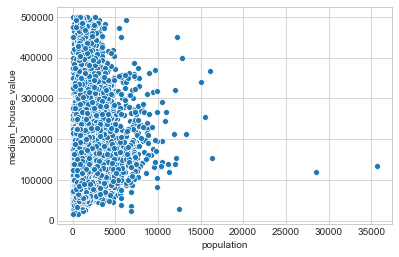

In [102]:
sns.scatterplot(data=housing,x='population',y='median_house_value')

In [103]:
# Create some new features
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

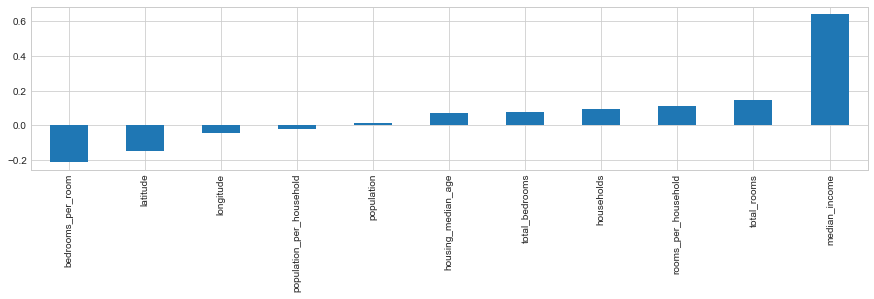

In [104]:
# Check the correlations again
plt.figure(figsize=(15,3))
housing.corr()['median_house_value'].sort_values(ascending=True)[:-1].plot(kind='bar')
plt.show()

In [105]:
# Prepare the data
housing_label = housing['median_house_value']
housing = housing.drop('median_house_value', axis=1)

housing_num = housing.drop('ocean_proximity',axis=1)
housing_cat = housing['ocean_proximity']

# Assign index values to columns
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# Create Custom Transformer
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """ Custom Transformer to create the additional features. """
    def __init__(self, add_bedrooms_per_room=True): # no *args or kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household= X[:, rooms_ix] / X[:, households_ix]
        population_per_household=X[:, population_ix] / X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Example of how to use the above class
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Create the pipeline for the numerical features
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

# Create a list of numeric and categorical features
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

# Full Column Transofmer object that will transform both numeric and categorical features
full_pipeline = ColumnTransformer([
    ('num_features', num_pipeline, num_attribs),
    ('cat_features', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

# Add back in the unscaled label ('median_house_value')
housing_prepared = np.c_[housing_prepared, housing_label]

In [106]:
# View the final data to see how everything came together
pd.DataFrame(housing_prepared).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-1.329378,1.036503,1.008388,-0.797584,-0.974341,-0.978308,-0.978946,2.960380,0.708065,-1.205171,-0.050757,0.708065,-0.050757,-1.069678,0.0,0.0,0.0,1.0,0.0,452600.0
1,-1.324393,1.027200,-0.590487,2.053478,1.349754,0.839604,1.661594,2.945223,0.382658,-1.042684,-0.092680,0.382658,-0.092680,-0.927323,0.0,0.0,0.0,1.0,0.0,358500.0
2,-1.334362,1.022548,1.887770,-0.528477,-0.829234,-0.826159,-0.845876,2.280353,1.276886,-1.506555,-0.027552,1.276886,-0.027552,-1.333722,0.0,0.0,0.0,1.0,0.0,352100.0
3,-1.339347,1.022548,1.887770,-0.616957,-0.722188,-0.771946,-0.736288,1.252288,0.199108,-0.536782,-0.051473,0.199108,-0.051473,-0.484101,0.0,0.0,0.0,1.0,0.0,341300.0
4,-1.339347,1.022548,1.887770,-0.455126,-0.615141,-0.765825,-0.631919,0.107935,0.401727,-0.754989,-0.085943,0.401727,-0.085943,-0.675273,0.0,0.0,0.0,1.0,0.0,342200.0


In [107]:
X = housing_prepared[:,:-1]
y = housing_prepared[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
# Fit some models
reg_lin = LinearRegression().fit(X_train, y_train)
y_pred_reg_lin = reg_lin.predict(X_test)

reg_rfor = RandomForestRegressor().fit(X_train, y_train)
y_pred_reg_rfor = reg_rfor.predict(X_test)

reg_xg = XGBRegressor().fit(X_train, y_train)
y_pred_reg_xg = reg_xg.predict(X_test)

reg_dtree = DecisionTreeRegressor().fit(X_train, y_train)
y_pred_reg_dtree = reg_dtree.predict(X_test)

reg_svr = SVR().fit(X_train, y_train)
y_pred_reg_svr = reg_svr.predict(X_test)


In [109]:
print('Linear Regression  R2: '+ np.str(metrics.r2_score(y_test,y_pred_reg_lin)))
print('Linear Regression  RMSE: '+ np.str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_reg_lin))))
print()
print('XGBoost Regression  R2: '+ np.str(metrics.r2_score(y_test,y_pred_reg_xg)))
print('XGBoost Regression  RMSE: '+ np.str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_reg_xg))))
print()
print('Support Vector Regression  R2: '+ np.str(metrics.r2_score(y_test,y_pred_reg_svr)))
print('Support Vector Regression  RMSE: '+ np.str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_reg_svr))))
print()
print('Decision Tree Regression  R2: '+ np.str(metrics.r2_score(y_test,y_pred_reg_dtree)))
print('Decision Tree Regression  RMSE: '+ np.str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_reg_dtree))))
print()
print('Random Forest Regression  R2: '+ np.str(metrics.r2_score(y_test,y_pred_reg_rfor)))
print('Random Forest Regression  RMSE: '+ np.str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_reg_rfor))))

Linear Regression  R2: 0.6159649086870851
Linear Regression  RMSE: 61880.598317227785

XGBoost Regression  R2: 0.807487571304506
XGBoost Regression  RMSE: 43812.540394407224

Support Vector Regression  R2: -0.03143572772908665
Support Vector Regression  RMSE: 101412.18373887162

Decision Tree Regression  R2: 0.6041830030423054
Decision Tree Regression  RMSE: 62822.652460403246

Random Forest Regression  R2: 0.7866074667827264
Random Forest Regression  RMSE: 46127.36630052015


In [110]:
# See if we can tweek the XGBoost model to get more performance

reg_xg = XGBRegressor(silent=1, eta=0.2).fit(X_train, y_train)
y_pred_reg_xg = reg_xg.predict(X_test)

print('XGBoost Regression  R2: '+ np.str(metrics.r2_score(y_test,y_pred_reg_xg)))
print('XGBoost Regression  RMSE: '+ np.str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_reg_xg))))

[20:06:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost Regression  R2: 0.8149983530191821
XGBoost Regression  RMSE: 42949.37482515827


In [111]:
# Perform Grid Search on XGBoost Regressor to see if it can be improved.
parameters = {'max_depth': range(3,10,2),
              'min_child_weight': range(1,6,2),
              'subsample': [0.5,0.75,0.9],
              'colsample_bytree': [0.5,0.75,0.9],
              'n_estimators': [100],
              'eta':[0.01,0.05,0.1]
             }

xgb_grid = GridSearchCV(XGBRegressor(),
                        parameters,
                        cv = 5,
                        n_jobs= -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  6.3min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [112]:
production_model = xgb_grid.best_estimator_
y_pred = production_model.predict(X_test)

print('XGBoost w/Tuning Regression  R2: '+ np.str(metrics.r2_score(y_test,y_pred)))
print('XGBoost w/Tuning Regression  RMSE: '+ np.str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

XGBoost w/Tuning Regression  R2: 0.817831417926473
XGBoost w/Tuning Regression  RMSE: 42619.24856056506


In [113]:
pd.DataFrame(production_model.feature_importances_)

,0
0,0.017969
1,0.018427
2,0.012315
3,0.005237
4,0.005179
5,0.005690
6,0.006677
7,0.122168
8,0.006858
9,0.014314
